In [1]:
import sys
sys.path.append("/home/fehrdelt/data_ssd/MedicalImaging_GIN/gradient_boosting")

import os
import lightgbm as lgb
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt




/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Get the training csv files containing segmentation volumes, clinical data and outcome

In [2]:
from make_training_csv import get_training_csv

In [3]:
extraction_methods = ["custom_nn", "matlab", "TTS"]
registration_methods = ["ANTS", "ANTS_hist_match", "LDDMM"]

for extraction in extraction_methods:
    for registration in registration_methods:
        get_training_csv(extraction, registration, "/home/fehrdelt/data_ssd/data/clinical_data")

<bound method NDFrame.head of       name supratentorial_IPH supratentorial_SAH supratentorial_Petechiae  \
0    P0001                  0                343                        0   
1    P0002                  0                  1                        0   
2    P0003                  0                103                        0   
3    P0004                  0                372                        0   
4    P0005                  0                 32                        0   
..     ...                ...                ...                      ...   
323  P0294                  0               1472                        0   
324  P0358                  0                 48                        2   
325  P0246                 65               1064                        0   
326  P0106              41920               2157                        0   
327  P0340                  0                102                        0   

    supratentorial_Edema infratentorial_IPH i

### Data 

In [2]:
DATA_DIRECTORY = "/home/fehrdelt/data_ssd/data/clinical_data/"

In [3]:
X = pd.read_csv(DATA_DIRECTORY+"cleaned_dataframe.csv")

X.head()

,age,hemocue_initial,fracas_du_bassin,catecholamines,pression_arterielle_systolique_PAS_arrivee_du_smur,pression_arterielle_diastolique_PAD_arrivee_du_smur,score_glasgow_initial,score_glasgow_moteur_initial,anomalie_pupillaire_prehospitalier,frequence_cardiaque_FC_arrivee_du_smur,arret_cardio_respiratoire_massage,penetrant_objet,ischemie_du_membre,hemorragie_externe,amputation
0,79.0,NaN,0.0,0.0,190.0,103.0,15.0,6.0,0.0,137.0,0.0,0.0,0.0,0.0,0.0
1,52.0,NaN,0.0,0.0,87.0,49.0,15.0,6.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0
2,23.0,NaN,0.0,0.0,100.0,60.0,15.0,6.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
3,42.0,13.1,0.0,0.0,101.0,64.0,14.0,6.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0
4,34.0,15.8,0.0,0.0,110.0,71.0,15.0,6.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0


In [4]:
y = pd.read_csv(DATA_DIRECTORY+"cleaned_dataframe_outcome.csv")
y.head()


,neurochir+pic
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [5]:
# !!! A executer qu'une seule fois !! 
# remove rows from X and Y where Y has nan


nan_indexes = y.loc[pd.isna(y["neurochir+pic"]), :].index # indexes where there is a nan value.
print(nan_indexes)

y = y.dropna()
X = X.drop(nan_indexes)

Index([68, 99, 111, 114, 133, 135, 145, 149, 155, 156, 166], dtype='int64')


In [6]:
imp = SimpleImputer(missing_values=np.nan, strategy="median")
imp.fit(X)
X = imp.transform(X)

In [7]:
y = y['neurochir+pic'].ravel()
y = [int(i) for i in y]

/data_local/data_hdd/fehrdelt/tmp/ipykernel_714427/1499797215.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y['neurochir+pic'].ravel()


##### DecisionTreeClassifier without reducing class imbalance

t-SNE (t-Distributed Stochastic Neighbor Embedding) visualisation

Text(0, 0.5, 't_SNE component 2')

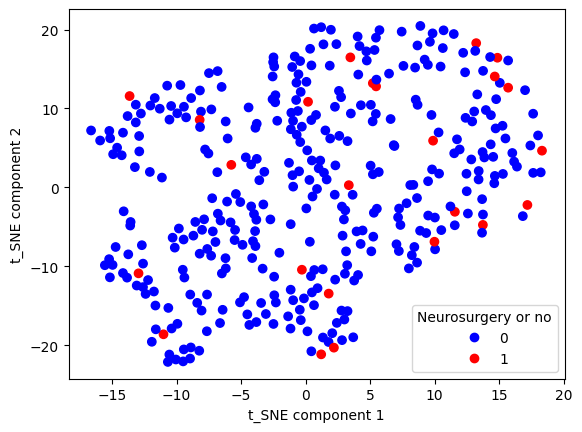

In [8]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X)

fig, ax = plt.subplots()

scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y, cmap='bwr')
legend = ax.legend(*scatter.legend_elements(), title="Neurosurgery or no")
plt.xlabel('t_SNE component 1')
plt.ylabel('t_SNE component 2')

UMAP (Uniform Manifold Approximation and Projection) visualization

/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Text(0, 0.5, 't_SNE component 2')

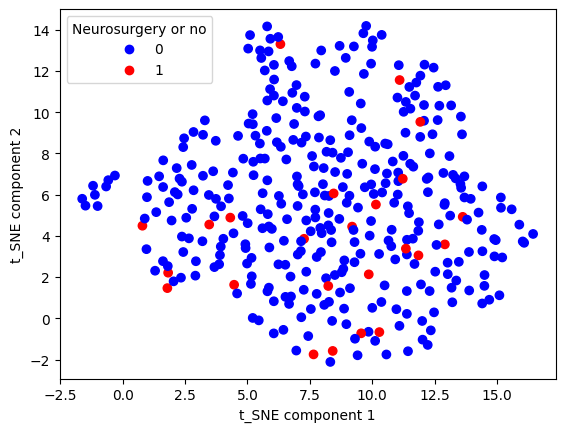

In [9]:
umap_model = umap.UMAP(n_neighbors=6, min_dist=1, n_components=2)
X_umap = umap_model.fit_transform(X)


fig, ax = plt.subplots()

scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='bwr')
legend = ax.legend(*scatter.legend_elements(), title="Neurosurgery or no")
plt.xlabel('t_SNE component 1')
plt.ylabel('t_SNE component 2')

In [10]:
#model = DecisionTreeClassifier()
model = HistGradientBoostingClassifier(categorical_features=[False, False, True, True, False, False, False, False, True, False, True, True, True, True, True])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores = cross_validate(model, X, y, scoring=['roc_auc', 'recall_macro'], cv=cv, n_jobs=-1)

#print(scores)

print('Mean ROC AUC: %.3f' % np.mean(scores['test_roc_auc']))
print('Mean recall macro: %.3f' % np.mean(scores['test_recall_macro']))

Mean ROC AUC: 0.787
Mean recall macro: 0.634


##### Same but with SMOTE oversampling

Text(0, 0.5, 't_SNE component 2')

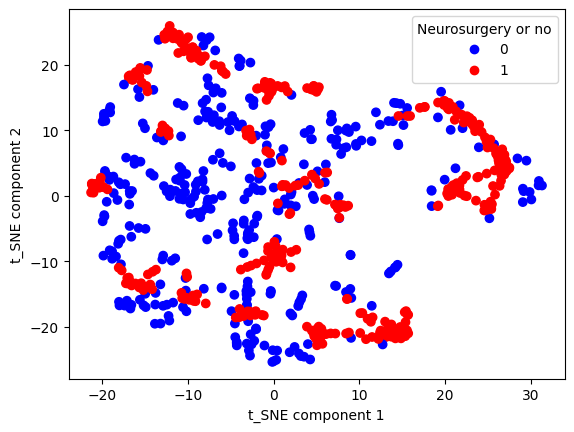

In [11]:
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X, y)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_over)

fig, ax = plt.subplots()

scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_over, cmap='bwr')
legend = ax.legend(*scatter.legend_elements(), title="Neurosurgery or no")
plt.xlabel('t_SNE component 1')
plt.ylabel('t_SNE component 2')

Text(0, 0.5, 't_SNE component 2')

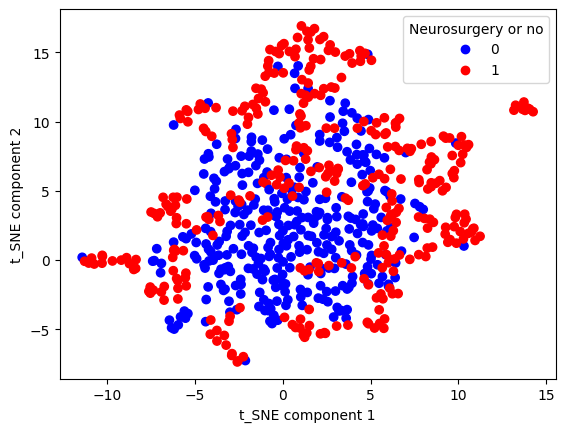

In [12]:
umap_model = umap.UMAP(n_neighbors=6, min_dist=1, n_components=2)
X_umap_over = umap_model.fit_transform(X_over)


fig, ax = plt.subplots()

scatter = ax.scatter(X_umap_over[:, 0], X_umap_over[:, 1], c=y_over, cmap='bwr')
legend = ax.legend(*scatter.legend_elements(), title="Neurosurgery or no")
plt.xlabel('t_SNE component 1')
plt.ylabel('t_SNE component 2')

In [13]:
#pipeline = Pipeline(steps=[('over', SMOTE()), ('model', DecisionTreeClassifier())])
pipeline_smote = Pipeline(steps=[('over', SMOTE()), ('model', HistGradientBoostingClassifier(categorical_features=[False, False, True, True, False, False, False, False, True, False, True, True, True, True, True]))])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_smote = cross_validate(pipeline_smote, X, y, scoring=['roc_auc', 'recall_macro'], cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % np.mean(scores_smote['test_roc_auc']))
print('Mean recall macro: %.3f' % np.mean(scores_smote['test_recall_macro']))

Mean ROC AUC: 0.805
Mean recall macro: 0.634


##### Same but with SMOTE oversampling and RandomUnderSampling

Text(0, 0.5, 't_SNE component 2')

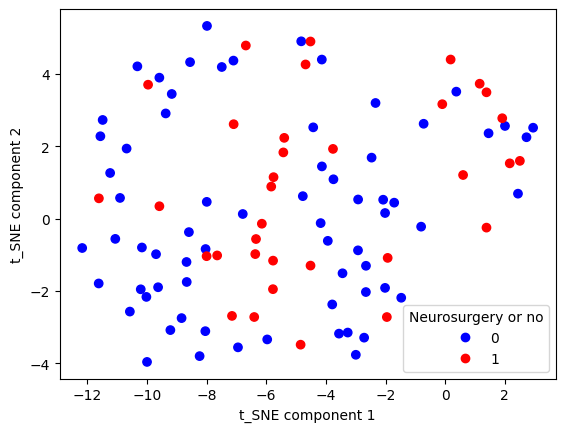

In [14]:
oversample = SMOTE()
pipeline_visu_smote_under = Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)), ('under', RandomUnderSampler(sampling_strategy=0.5))])
X_over_under, y_over_under = pipeline_visu_smote_under.fit_resample(X, y)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_over_under)

fig, ax = plt.subplots()

scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_over_under, cmap='bwr')
legend = ax.legend(*scatter.legend_elements(), title="Neurosurgery or no")
plt.xlabel('t_SNE component 1')
plt.ylabel('t_SNE component 2')

In [15]:
#pipeline = Pipeline(steps=[('over', SMOTE()), ('model', DecisionTreeClassifier())])
pipeline_smote_under = Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier(categorical_features=[False, False, True, True, False, False, False, False, True, False, True, True, True, True, True]))])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_smote_undersampling = cross_validate(pipeline_smote_under, X, y, scoring=['roc_auc', 'recall_macro'], cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % np.mean(scores_smote['test_roc_auc']))
print('Mean recall macro: %.3f' % np.mean(scores_smote['test_recall_macro']))

Mean ROC AUC: 0.805
Mean recall macro: 0.634


### LightGBM

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
train_data = lgb.Dataset(X_train, label=Y_train, categorical_feature=["fracas_du_bassin", "catecholamines", "anomalie_pupillaire_prehospitalier", "arret_cardio_respiratoire_massage", "penetrant_objet", "ischemie_du_membre", "hemorragie_externe", "amputation"]) # categorical features

In [ ]:
# Define parameters for GBDT
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 11,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
 
# Train the GBDT model
gbm = lgb.train(params, train_data, num_boost_round=100)
 
# Make predictions on the test set
Y_pred = gbm.predict(X_test)
 
# Evaluate the model
report = classification_report(Y_test, (Y_pred > 0.5).astype(int))
print(report)

### Sklearn HistGradientBoostingClassifier + Imbalanced-learn RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate


model = make_pipeline(

    RandomUnderSampler(random_state=0),
    HistGradientBoostingClassifier(random_state=0)

)

cv_results = cross_validate(

    model, X_train, Y_train, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True,
    n_jobs=-1

)

print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}"
)